> This is a self-correcting activity generated by [nbgrader](https://nbgrader.readthedocs.io). Fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Run subsequent cells to check your code.

---

# Distinguish dogs vs. cats (Keras)

In this activity, the goal is to distinguish the animals pictured in these images between cats and dogs.

The 2,000 images used in this kata are excerpted from the [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/) dataset available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

![Woof Meow](images/woof_meow.jpg)

## Environment setup

In [1]:
# The Python Imaging Library is needed to display images 
!pip install pillow

In [2]:
# Import base packages
import os
import zipfile
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [3]:
# Setup plots
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()

In [31]:
# Import ML packages (edit this list if needed)
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
print(f'Keras version: {tf.keras.__version__}')

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Dropout
from tensorflow.keras.applications import VGG16

#tf.config.list_physical_devices()
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

TensorFlow version: 2.3.1
Keras version: 2.4.0
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



## Utility functions

In [5]:
def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy"""

    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()

    acc = history.history['accuracy']

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if 'val_accuracy' in history.history:
        val_acc = history.history['val_accuracy']
        plt.plot(epochs, val_acc, 'o-', label='Validation acc')
        final_val_acc = val_acc[-1]
        title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
    plt.title(title)
    plt.legend()

## Step 1: Loading the data

In [8]:
# Downloading our example data, a .zip of 2,000 JPG pictures, and extracting it locally in `/tmp`
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-10-08 11:27:54--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.198.80, 172.217.171.208, 216.58.205.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.198.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

ed.zip               16%[==>                 ]  10,65M   490KB/s    eta 1m 43s ^C


In [11]:
# Extracting zip file to the base directory `/tmp/cats_and_dogs_filtered`
''''local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
'''
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Step 2: Explore data

In [12]:
print(f'Training cat images: {len(os.listdir(train_cats_dir))}')
print(f'Training dog images: {len(os.listdir(train_dogs_dir))}')
print(f'Validation cat images: {len(os.listdir(validation_cats_dir))}')
print(f'Validation dog images: {len(os.listdir(validation_dogs_dir))}')

# Display some images files for cats and dogs
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])
train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

Training cat images: 1000
Training dog images: 1000
Validation cat images: 500
Validation dog images: 500
['cat.721.jpg', 'cat.570.jpg', 'cat.61.jpg', 'cat.399.jpg', 'cat.587.jpg', 'cat.892.jpg', 'cat.85.jpg', 'cat.634.jpg', 'cat.148.jpg', 'cat.504.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


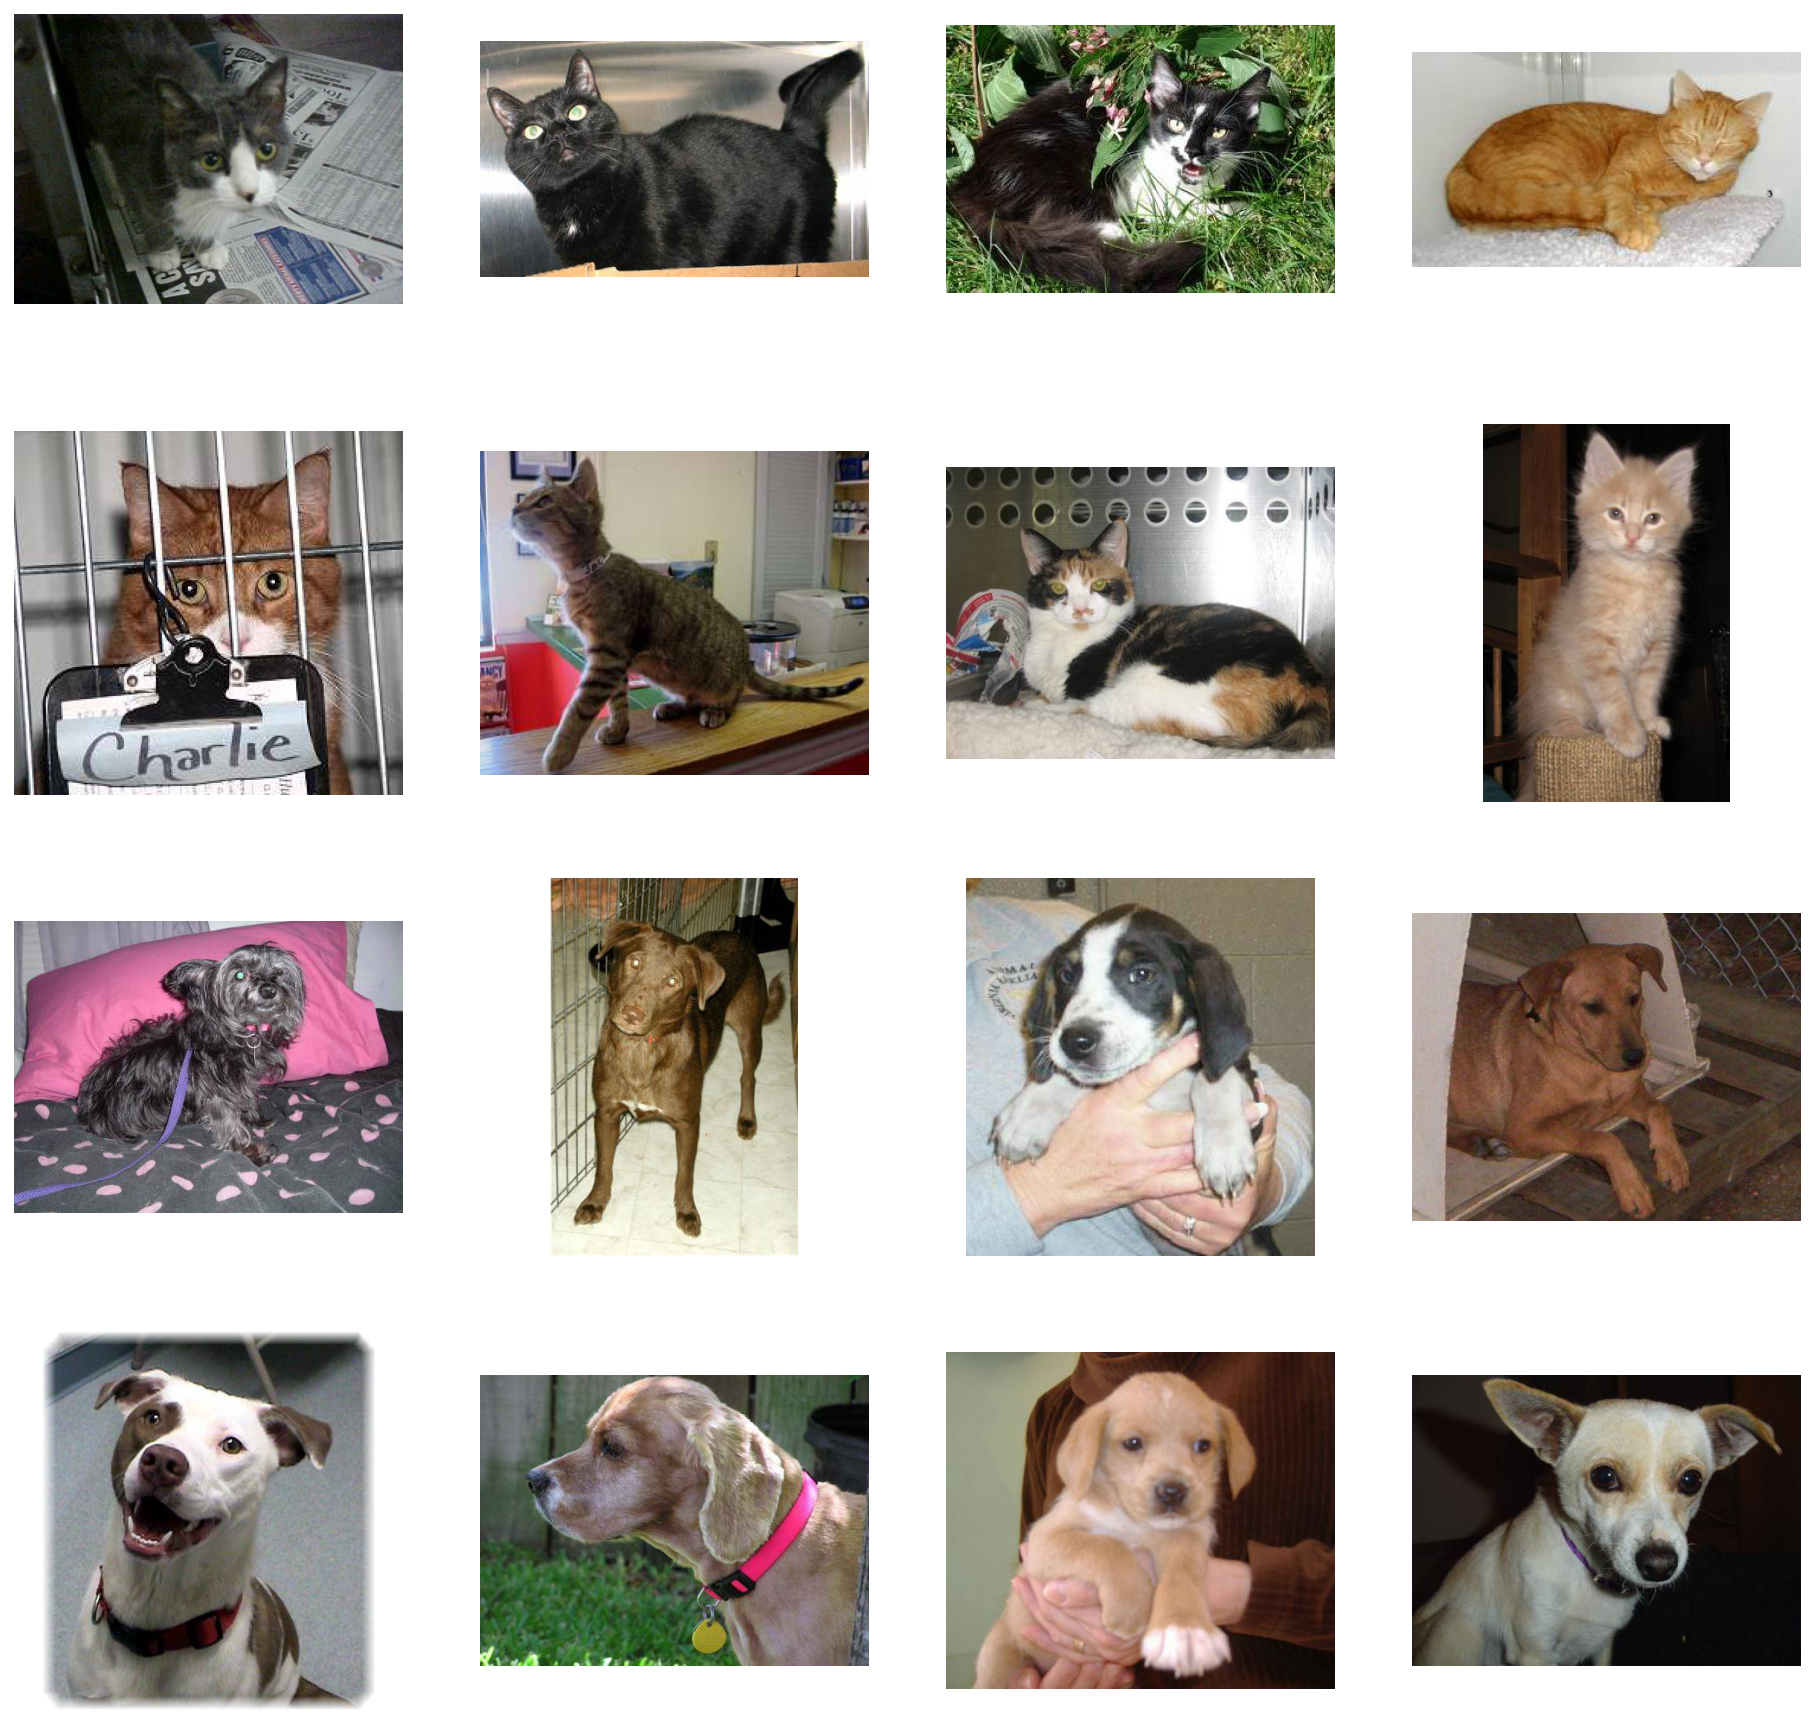

In [13]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Step 3 : training a model

In [14]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Question

Create a CNN model able to be trained on 150x150x3 images. Show its summary with the `model.summary()`method.

In [36]:
# Create CNN model

model = Sequential()

# Convolution + pooling layers
model.add(
    Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(150, 150, 3))
)
model.add(MaxPooling2D(2))

model.add(
    Conv2D(filters=32, kernel_size=3, activation='relu')
)
model.add(MaxPooling2D(2))

model.add(
    Conv2D(filters=64, kernel_size=3, activation='relu')
)
model.add(MaxPooling2D(2))

# Flatten data to fit in Dense layers
model.add(Flatten())

# Fully connected layer
model.add(Dense(512, activation='relu'))

# Fight overfitting
model.add(Dropout(0.5))

# Classification layer
model.add(Dense(1, activation='sigmoid'))

In [37]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 18496)            

### Question

Compile and train your model to reach a validation accuracy > 70%.

In [38]:
# Compile and train the model
model.compile('adam',
              'binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=1)

Epoch 1/15
100/100 [==============================] - 26s 263ms/step - loss: 0.7020 - accuracy: 0.5245 - val_loss: 0.6900 - val_accuracy: 0.6140
Epoch 2/15
100/100 [==============================] - 26s 260ms/step - loss: 0.6504 - accuracy: 0.6150 - val_loss: 0.6235 - val_accuracy: 0.6770
Epoch 3/15
100/100 [==============================] - 26s 263ms/step - loss: 0.5692 - accuracy: 0.6970 - val_loss: 0.6511 - val_accuracy: 0.6460
Epoch 4/15
100/100 [==============================] - 26s 264ms/step - loss: 0.4852 - accuracy: 0.7835 - val_loss: 0.5784 - val_accuracy: 0.7060
Epoch 5/15
100/100 [==============================] - 27s 267ms/step - loss: 0.3871 - accuracy: 0.8240 - val_loss: 0.6398 - val_accuracy: 0.6920
Epoch 6/15
100/100 [==============================] - 28s 281ms/step - loss: 0.2994 - accuracy: 0.8625 - val_loss: 0.6123 - val_accuracy: 0.7180
Epoch 7/15
100/100 [==============================] - 29s 287ms/step - loss: 0.2191 - accuracy: 0.9160 - val_loss: 0.7377 - val_ac

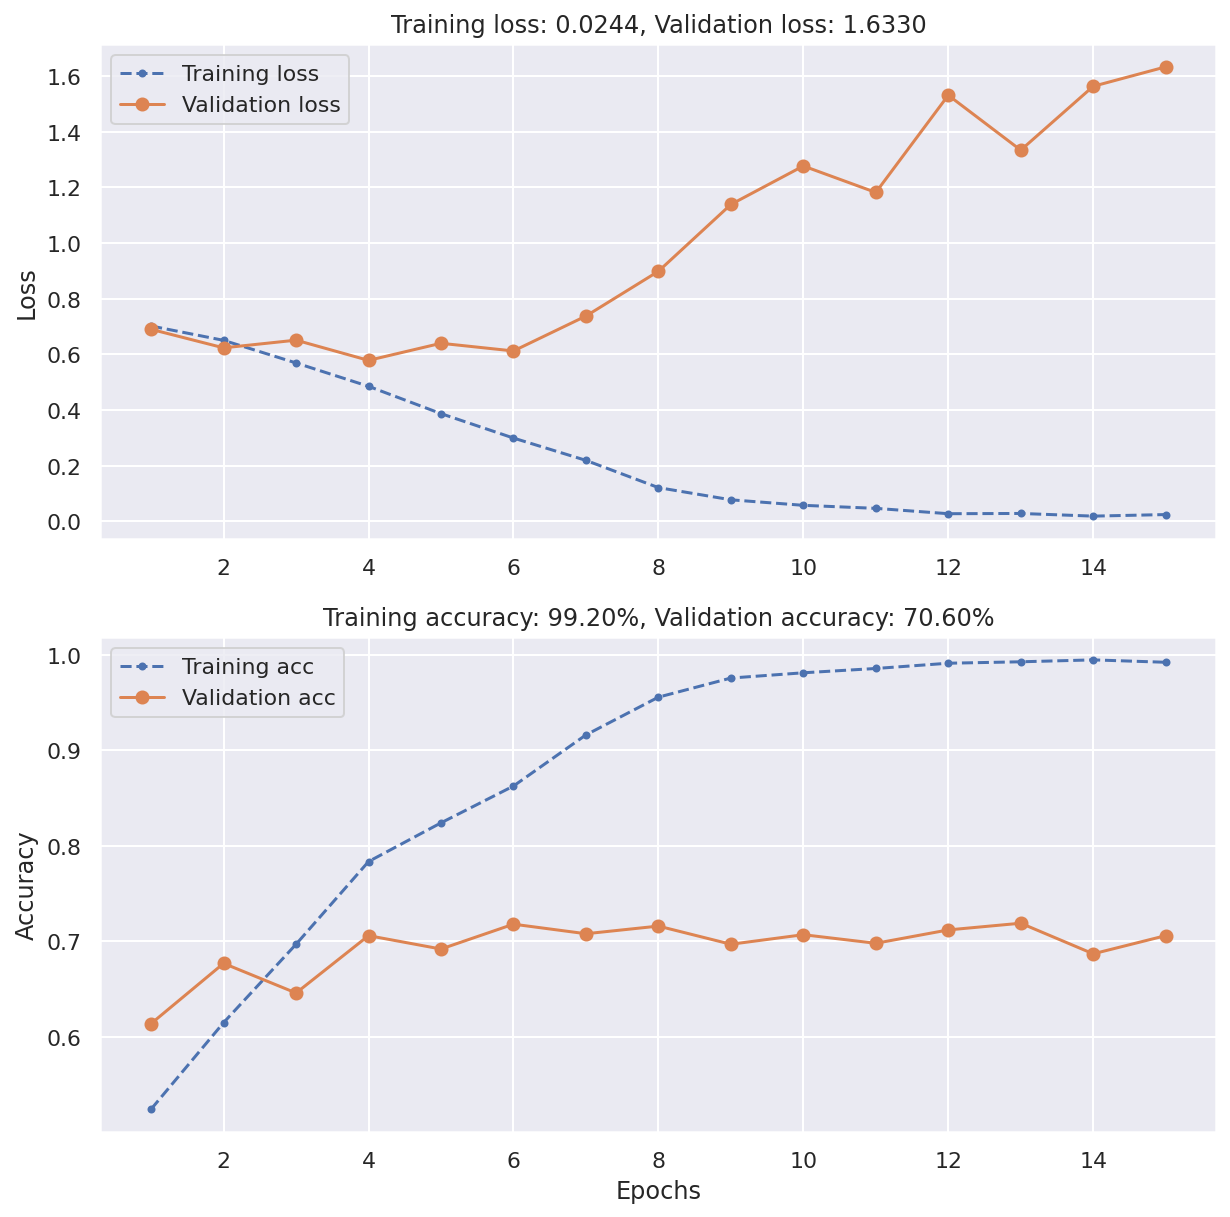

In [39]:
# Show training history
plot_loss_acc(history)

In [40]:
# Retrieve final validation accuracy
val_acc = history.history['val_accuracy'][-1]

# Assert final accuracy
assert val_acc > 0.68

## Step 4: Preventing overfitting

### Adding data augmentation

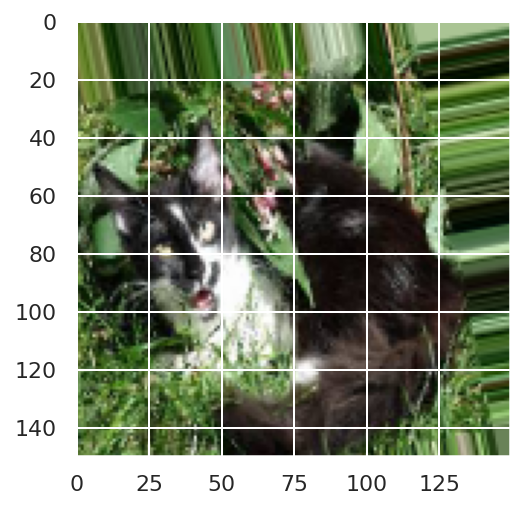

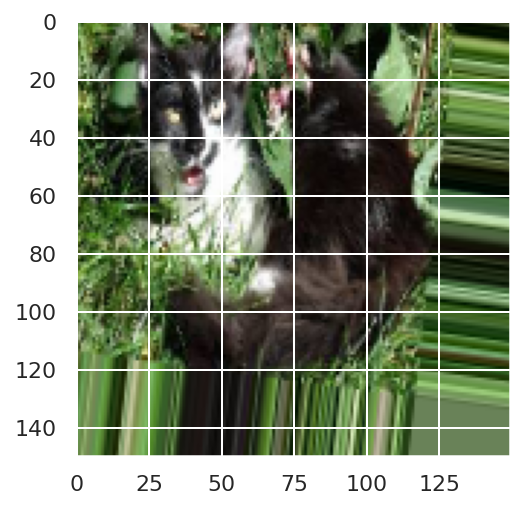

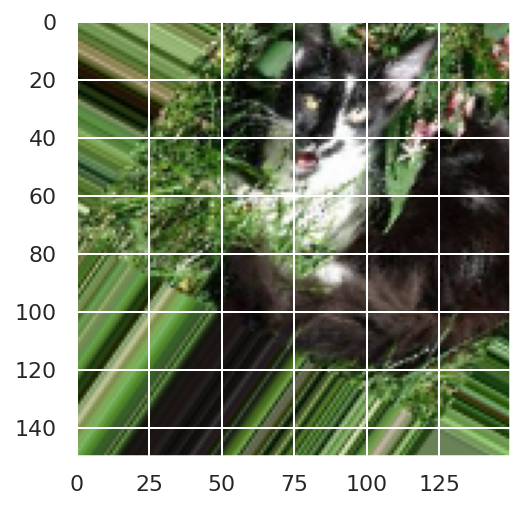

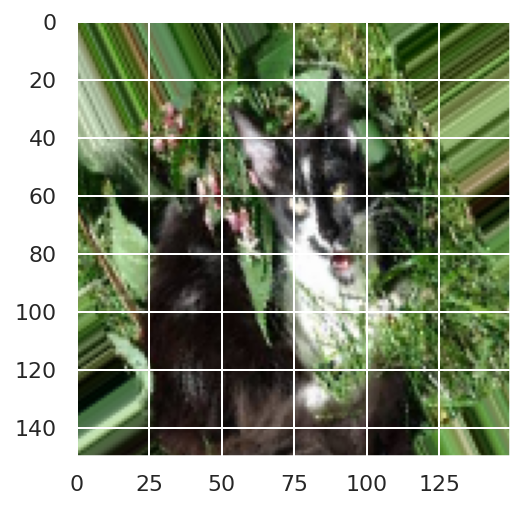

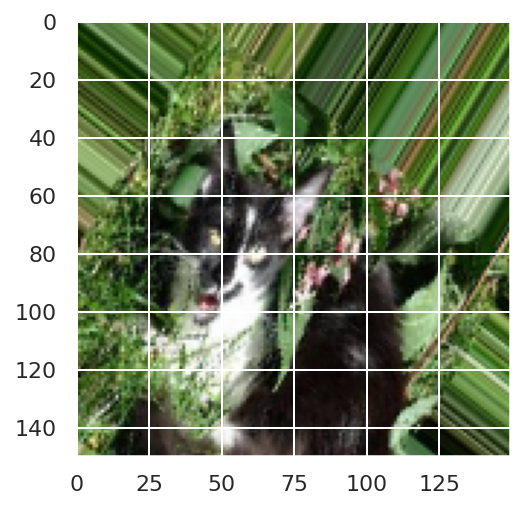

In [41]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i, figsize=(4, 4))
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

In [42]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Adding Dropout

### Question

Create a new model with a `Dropout` layer to your model just before the output layer.

In [ ]:
# YOUR CODE HERE

### Question

Compile and train your model to reach a validation accuracy > 73%.

In [ ]:
# Compile and train the model
model.compile('adam',
              'binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=1)

In [ ]:
# Show training history
plot_loss_acc(history)

In [ ]:
# Retrieve final validation accuracy
val_acc = history.history['val_accuracy'][-1]

# Assert final accuracy
assert val_acc > 0.73

## Step 5: Using a pretrained model

### Question

Implement feature extraction, using the convolution base of VGG16 in the `conv_base`variable.

In [ ]:
# YOUR CODE HERE

conv_base.summary()

### Question

Add a Dense classifier on top of the convolutional base.

In [ ]:
# YOUR CODE HERE

model.summary()

### Question

Compile and train your model to reach a validation accuracy > 87%.

In [ ]:
# Compile and train the model

model.compile('adam',
              'binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=1)

In [ ]:
# Show training history
plot_loss_acc(history)

In [ ]:
# Retrieve final validation accuracy
val_acc = history.history['val_accuracy'][-1]

# Assert final accuracy
assert val_acc > 0.87

## TODO

- Show images dimension
- Put model summary on a specific slide
- Visualizing intermediate layers